In [252]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import corner

In [253]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)


    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


In [254]:
# Functions to load data

def loadZLessThanOneHalf():
    z_data = SCP_data["Redshift"].to_numpy()
    mu_data = SCP_data["Distance modulus"].to_numpy()
    sigma_mu = SCP_data["Distance modulus error"].to_numpy()

    mask = z_data < 0.5

    z_data = z_data[mask]
    mu_data = mu_data[mask]
    sigma_mu = sigma_mu[mask]

    print(f"Lenght of data: {len(z_data)}")
    return z_data, mu_data, sigma_mu

def LoadAll():
    z_data = SCP_data["Redshift"].to_numpy()
    mu_data = SCP_data["Distance modulus"].to_numpy()
    sigma_mu = SCP_data["Distance modulus error"].to_numpy()
    print(f"lenght of data: {len(z_data)}")
    return z_data, mu_data, sigma_mu


In [176]:
#Load data for z < 0.5
z_data ,mu_data ,sigma_mu = loadZLessThanOneHalf()

#Constants
N_d = len(z_data)
num_draws = int(100000)
num_tune = int(num_draws * 0.1)
c = 2.99*10**5 # speed of light (km/s)

def distance_modulus(z, H0, q0):
    d_L = (c / H0) * (z + 0.5 * (1 - q0) * z**2)
    return 5 * np.log10(d_L) + 25

with pm.Model() as model:
    # Priors
    H0 = pm.Uniform("H0",lower = 50, upper = 100, initval = 70)  
    q0 = pm.Uniform("q0",lower = -2, upper = 2, initval = -0.5)  
    sigma2 = pm.InverseGamma("sigma2", alpha=2, beta=2)  
    
    # Weights
    weights = 1/(sigma_mu)
    norm_weights = weights * (N_d/np.sum(weights))

    # Model predictions for distance modulus
    mu_model = distance_modulus(z_data, H0, q0)

    # Likelihood
    mu_obs = pm.Normal("mu_obs", mu=mu_model, sigma = np.sqrt(sigma2) / (norm_weights), observed=mu_data)

    # Sampling
    model.debug()
    trace = pm.sample(draws=num_draws, tune=num_tune,  return_inferencedata=True, progressbar=True, discard_tuned_samples = False)


Lenght of data: 412
point={'H0_interval__': array(-0.40546511), 'q0_interval__': array(-0.51082562), 'sigma2_log__': array(0.69314718)}

No problems found


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [H0, q0, sigma2]


Output()

Sampling 4 chains for 10_000 tune and 100_000 draw iterations (40_000 + 400_000 draws total) took 262 seconds.


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
C:\Users\marku\AppData\Local\Temp\ipykernel_19312\2882163529.py:6: SyntaxWarning: invalid escape sequence '\s'
  new_titles = ["Hubble Parameter ($H_0$)","Hubble Parameter ($H_0$)", "Deceleration Parameter ($q_0$)","Deceleration Parameter ($q_0$)", "Variance ($\sigma^2$)","Variance ($\sigma^2$)"]
C:\Users\marku\AppData\Local\Temp\ipykernel_19312\2882163529.py:6: SyntaxWarning: invalid escape sequence '\s'
  new_titles = ["Hubble Parameter ($H_0$)","Hubble Parameter ($H_0$)", "Deceleration 

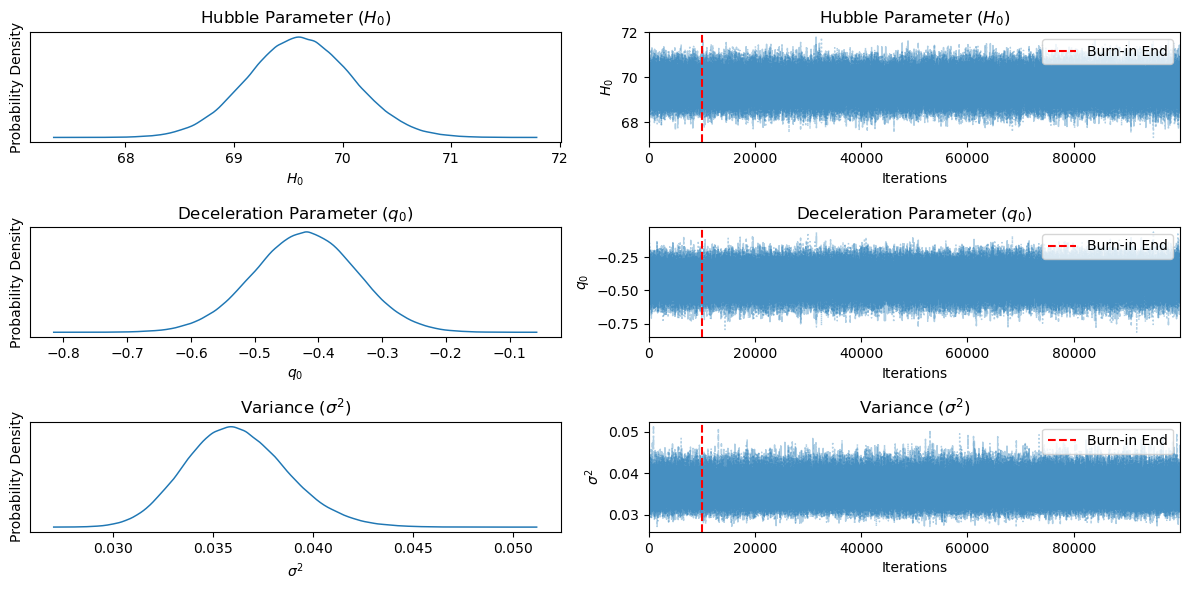

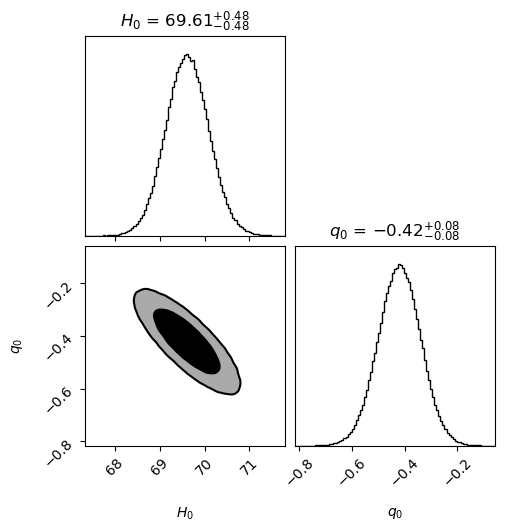

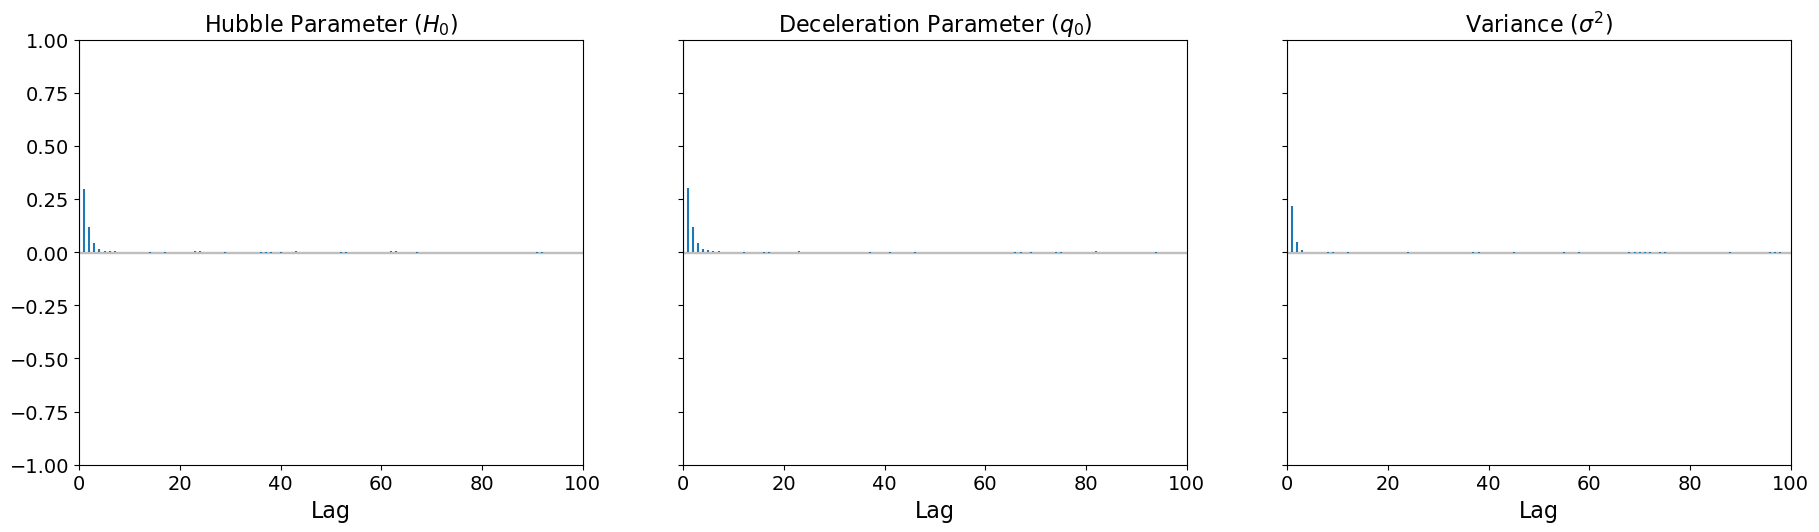

In [255]:
trace1 = trace.posterior

labels = ["H0 (Hubble constant)", "q0 (Deceleration parameter)", "sigma2 (Variance)"]

var_names = ["H0", "q0", "sigma2"]
new_titles = ["Hubble Parameter ($H_0$)","Hubble Parameter ($H_0$)", "Deceleration Parameter ($q_0$)","Deceleration Parameter ($q_0$)", "Variance ($\sigma^2$)","Variance ($\sigma^2$)"] 

# Plot the trace
az.plot_trace(trace1, var_names=var_names, combined=True)
fig = plt.gcf()
# Set custom titles
x_labels = ["$H_0$", "Iterations", "$q_0$","Iterations", "$\sigma^2$", "Iterations"]
y_labels = ["Probability Density","$H_0$", "Probability Density","$q_0$", "Probability Density","$\sigma^2$"]

burn_in_steps = num_tune
for i, ax in enumerate(fig.axes):
    # Check if the current axis is in the right column (column 2)
    row, col = divmod(i, 2)  # Assuming a 3x2 grid, this gives the row and column for each axis
    if col == 1:  # Column 2 (rightmost column)
        ax.axvline(x=burn_in_steps, color='red', linestyle='--', label='Burn-in End')
        ax.legend(loc="upper right")

for ax, new_title, x_label, y_label in zip(plt.gcf().axes, new_titles, x_labels, y_labels):
    ax.set_title(new_title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


plt.tight_layout()
plt.savefig("MC_chain.pdf")
plt.show()

#samples = trace.posterior[["H0", "q0"]].values
posterior = trace.posterior
samples = np.column_stack([
    posterior["H0"].values.flatten(), 
    posterior["q0"].values.flatten(), 
    #posterior["sigma2"].values.flatten()
])
param_names = [r"$H_0$", r"$q_0$"]
fig = corner.corner(
    samples,
    labels=param_names,
    bins = 99,
    show_titles=True,
    levels = (0.68,0.95,),
    smooth=True, 
    fill_contours = True,
    plot_datapoints = False,
    show_quantiles = True,
    titles=[r"$H_0$", r"$q_0$"]
)

plt.savefig("cornerplot.pdf")

# Plot autocorrelation for each variable with different colors
az.plot_autocorr(trace, var_names=["H0", "q0", "sigma2"], combined=True)
x_labels = ["Lag","Lag","Lag" ]
#y_labels = ["Probability Density","$H_0$", "Probability Density","$q_0$", "Probability Density","$\sigma^2$"]
new_titles = ["Hubble Parameter ($H_0$)", "Deceleration Parameter ($q_0$)","Variance ($\sigma^2$)"] 


for ax, new_title, x_label, y_label in zip(plt.gcf().axes, new_titles, x_labels, y_labels):
    ax.set_title(new_title,fontsize = 16)
    ax.set_xlabel(x_label,fontsize = 16)
    #ax.set_ylabel(y_label)

plt.savefig("autocorr.pdf")
# Autocorrelation plot
# Set labels and title
plt.show()

lenght of data: 580


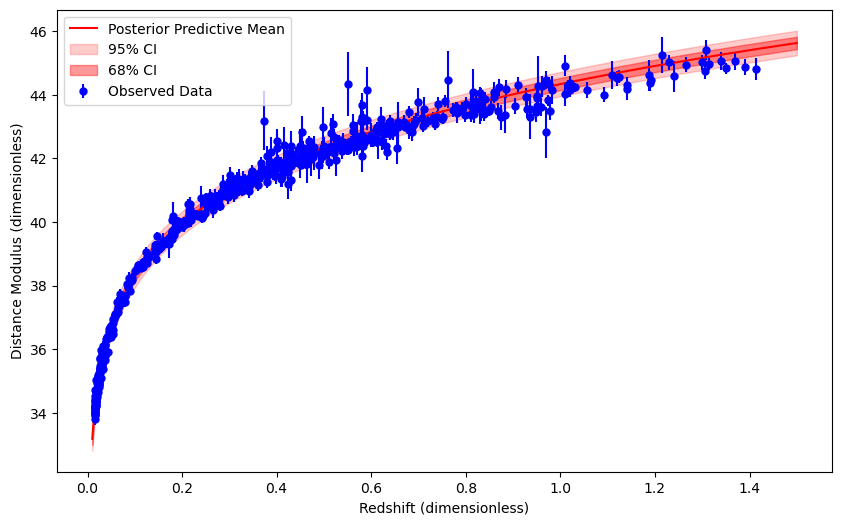

In [270]:
# Generate posterior predictive plot for distance modulus vs redshift
# Define redshift values for prediction
z_data ,mu_data ,sigma_mu = LoadAll()

z_pred = np.linspace(0.01, 1.5, 500)

# Sample from posterior distributions of H0 and q0 to predict distance modulus
mu_pred_samples = []
for h0, q0, sigma2 in zip(trace.posterior["H0"].values.flatten(), trace.posterior["q0"].values.flatten(), trace.posterior["sigma2"].values.flatten()):
    mu_pred = distance_modulus(z_pred, h0, q0)
    mu_pred_samples.append(mu_pred + np.random.normal(0, np.sqrt(sigma2), mu_pred.shape))

# Convert to numpy array for easier manipulation
mu_pred_samples = np.array(mu_pred_samples)
mu_pred_mean = np.mean(mu_pred_samples, axis=0)
mu_pred_68 = np.percentile(mu_pred_samples, [16, 84], axis=0)  # 68% confidence interval
mu_pred_95 = np.percentile(mu_pred_samples, [2.5, 97.5], axis=0)  # 95% confidence interval

# Plot data and model predictions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(z_data, mu_data, yerr=sigma_mu, fmt="o", label="Observed Data", color="blue", markersize=5)
plt.plot(z_pred, mu_pred_mean, color="red", label="Posterior Predictive Mean")
plt.fill_between(z_pred, mu_pred_95[0], mu_pred_95[1], color="red", alpha=0.2, label="95% CI")
plt.fill_between(z_pred, mu_pred_68[0], mu_pred_68[1], color="red", alpha=0.4, label="68% CI")
plt.xlabel("Redshift (dimensionless)")
plt.ylabel("Distance Modulus (dimensionless)")
plt.legend()
plt.savefig("Posterior_predictive.pdf")
plt.show()


In [45]:
# Calculate the 95% credible interval for q0
q0_samples = trace.posterior["q0"].values.flatten()
q0_mean = np.mean(q0_samples)
q0_lower = np.percentile(q0_samples, 2.5)
q0_upper = np.percentile(q0_samples, 97.5)

print(f"Posterior mean of q0: {q0_mean}")
print(f"95% credible interval for q0: [{q0_lower}, {q0_upper}]")

# Check if the credible interval supports an accelerating universe
if q0_upper < 0:
    print("Evidence supports an accelerating universe (q0 < 0).")
else:
    print("No strong evidence for an accelerating universe (q0 credible interval includes zero).")


Posterior mean of q0: -0.4210215125992547
95% credible interval for q0: [-0.5807101051919679, -0.2644456695160966]
Evidence supports an accelerating universe (q0 < 0).


In [186]:
# Calculate and print summary statistics for H0, q0, and sigma
H0_samples = trace.posterior["H0"].values.flatten()
sigma_samples = trace.posterior["sigma2"].values.flatten()

H0_mean = np.mean(H0_samples)
H0_lower, H0_upper = np.percentile(H0_samples, [2.5, 97.5])

sigma_mean = np.mean(sigma_samples)
sigma_lower, sigma_upper = np.percentile(sigma_samples, [2.5, 97.5])

print(f"Posterior mean of H0: {H0_mean}")
print(f"95% credible interval for H0: [{H0_lower}, {H0_upper}]")

print(f"Posterior mean of sigma: {sigma_mean}")
print(f"95% credible interval for sigma: [{sigma_lower}, {sigma_upper}]")


Posterior mean of H0: 69.61034038770158
95% credible interval for H0: [68.67106559606809, 70.5642767567733]
Posterior mean of sigma: 0.03617524010647732
95% credible interval for sigma: [0.03156241896281881, 0.041460512767818994]


In [47]:
# Display diagnostics
az.summary(trace, var_names=["H0", "q0", "sigma2"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H0,69.611,0.482,68.707,70.516,0.001,0.001,214391.0,234825.0,1.0
q0,-0.421,0.081,-0.574,-0.271,0.000,0.000,215800.0,231241.0,1.0
sigma2,0.036,0.003,0.031,0.041,0.000,0.000,257881.0,256123.0,1.0


### **Task 2**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
import pymc as pm
import pymc.math as pmm
import arviz as az
import emcee


In [ ]:
# Load the SCP dataset
datafile = open('SCPUnion2.1_mu_vs_z.txt', 'r')
SCP_data = pd.read_table(datafile, comment='#',
                         names=['SN name', 'Redshift', 'Distance modulus',
                                'Distance modulus error', 'P low mass'])

# Extract relevant columns
z_data = SCP_data["Redshift"].to_numpy()
mu_data = SCP_data["Distance modulus"].to_numpy()
sigma_mu = SCP_data["Distance modulus error"].to_numpy()

# Verify shapes
print(f"Redshift data: {z_data.shape}")
print(f"Distance modulus data: {mu_data.shape}")
print(f"Measurement errors: {sigma_mu.shape}")


Redshift data: (580,)
Distance modulus data: (580,)
Measurement errors: (580,)


In [237]:
# Constants
c = 3e5  # Speed of light in km/s
H0 = 70  # Fixed Hubble parameter in km/s/Mpc

# E(z) for ΛCDM
def E_LCDM(z, omega_m):
    omega_lambda = 1 - omega_m
    return np.sqrt(omega_m * (1 + z)**3 + omega_lambda)

# E(z) for wCDM
def E_wCDM(z, omega_m, w):
    omega_lambda = 1 - omega_m
    return np.sqrt(omega_m * (1 + z)**3 + omega_lambda * (1 + z)**(3 * (1 + w)))

# Luminosity distance
def d_L(z, E_func, *params):
    integrand = lambda z_: 1 / E_func(z_, *params)
    integral, error = quad(integrand, 0, z)
    return (c / H0) * (1 + z) * integral

# Distance modulus
def mu(z, E_func, *params):
    d_L_val = d_L(z, E_func, *params)
    return 5 * np.log10(d_L_val) + 25

In [238]:
# Negative log-likelihood
def negative_log_likelihood(params, z_data, mu_data, sigma_mu, E_func):
    mu_model = np.array([mu(z, E_func, *params) for z in z_data])
    return 0.5 * np.sum(((mu_data - mu_model) / sigma_mu)**2)

In [ ]:
# Fit ΛCDM
initial_guess_LCDM = [0.3]
bounds_LCDM = [(0, 2)]
result_LCDM = minimize(
    negative_log_likelihood, initial_guess_LCDM,
    args=(z_data, mu_data, sigma_mu, E_LCDM),
    bounds=bounds_LCDM, method = 'Nelder-mead',
)
omega_m_LCDM = result_LCDM.x
print(f"ΛCDM Best-fit: Omega_m = {omega_m_LCDM}, Omega_lambda = {1 - omega_m_LCDM}")

ΛCDM Best-fit: Omega_m = [0.27972656], Omega_lambda = [0.72027344]


In [ ]:
# Fit wCDM
initial_guess_wCDM = [0.3, -1]
bounds_wCDM = [(0, 2), (-2, 2)]
result_wCDM = minimize(
    negative_log_likelihood, initial_guess_wCDM,
    args=(z_data, mu_data, sigma_mu, E_wCDM),
    bounds=bounds_wCDM, method = 'Nelder-mead',
)
omega_m_wCDM, w_wCDM = result_wCDM.x
print(f"wCDM Best-fit: Omega_m = {omega_m_wCDM}, Omega_lambda = {1 - omega_m_wCDM}, w = {w_wCDM}")


wCDM Best-fit: Omega_m = 0.27552498981027806, Omega_lambda = 0.7244750101897219, w = -0.990255672767579


In [ ]:
# AIC and BIC computation
def compute_AIC_BIC(n_params, n_data, log_likelihood):
    AIC = 2 * n_params - 2 * log_likelihood
    BIC = n_params * np.log(n_data) - 2 * log_likelihood
    return AIC, BIC

n_data = len(z_data)

# ΛCDM
log_likelihood_LCDM = -negative_log_likelihood([omega_m_LCDM], z_data, mu_data, sigma_mu, E_LCDM)
AIC_LCDM, BIC_LCDM = compute_AIC_BIC(1, n_data, log_likelihood_LCDM)

# wCDM
log_likelihood_wCDM = -negative_log_likelihood([omega_m_wCDM, w_wCDM], z_data, mu_data, sigma_mu, E_wCDM)
AIC_wCDM, BIC_wCDM = compute_AIC_BIC(2, n_data, log_likelihood_wCDM)

print(f"ΛCDM: AIC = {AIC_LCDM}, BIC = {BIC_LCDM}")
print(f"wCDM: AIC = {AIC_wCDM}, BIC = {BIC_wCDM}")


580
ΛCDM: AIC = 564.2487754566539, BIC = 568.6118035601944
wCDM: AIC = 566.2443309092147, BIC = 574.9703871162956


C:\Users\marku\AppData\Local\Temp\ipykernel_19312\3292259201.py:24: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(d_L_val) + 25


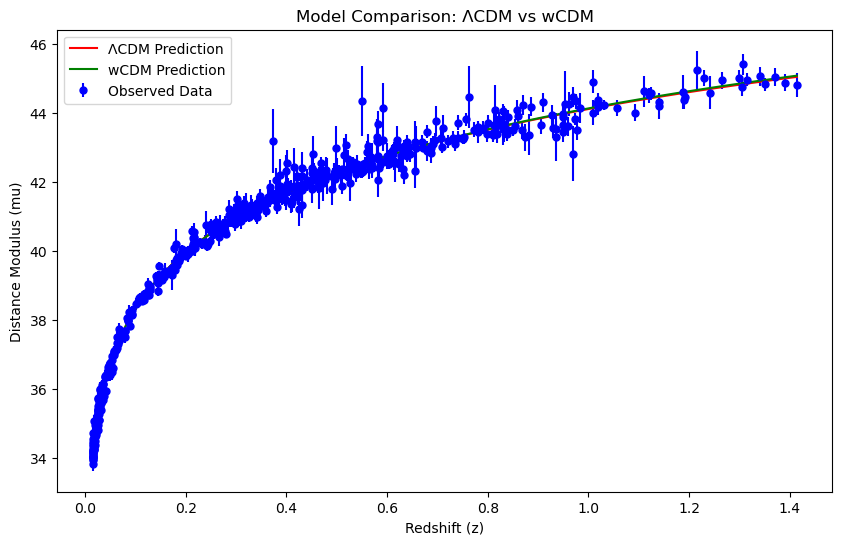

In [ ]:
# Generate predictions
z_pred = np.linspace(0.01, max(z_data), 100)
mu_LCDM_pred = [mu(z, E_LCDM, omega_m_LCDM) for z in z_pred]
mu_wCDM_pred = [mu(z, E_wCDM, omega_m_wCDM, w_wCDM) for z in z_pred]

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(z_data, mu_data, yerr=sigma_mu, fmt="o", label="Observed Data", color="blue", markersize=5)
plt.plot(z_pred, mu_LCDM_pred, label="ΛCDM Prediction", color="red")
plt.plot(z_pred, mu_wCDM_pred, label="wCDM Prediction", color="green")
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (mu)")
plt.legend()
plt.title("Model Comparison: ΛCDM vs wCDM")
plt.show()


In [ ]:
def E_LCDM_post(z, omega_m):
    omega_lambda = 1 - omega_m
    return np.sqrt(omega_m * (1 + z)**3 + omega_lambda) 

def d_L_post(z, omega_m):
    integrand = lambda z_: 1 / E_LCDM_post(z_, omega_m)
    integral, _ = quad(integrand, 0, z)
    return (c / H0) * (1 + z) * integral

# Distance modulus
def mu_LCDM(z, omega_m):
    return 5 * np.log10(d_L_post(z, omega_m)) + 25

def log_likelihood(omega_m, z_data, mu, sigma_mu):
    model = np.array([mu_LCDM(zi, omega_m) for zi in z_data])
    return -0.5 * np.sum(((mu - model) / sigma_mu) ** 2)

def log_prior(omega_m):
    if 0 <= omega_m <= 1:
        return 0
    return -np.inf

def log_posterior(omega_m, z_data, mu_data, sigma_mu):
    lp = log_prior(omega_m)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(omega_m, z_data, mu_data, sigma_mu)

ndim, nwalkers = 1, 10
start_value = 0.27
pos = [start_value + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data, mu_data, sigma_mu))
sampler.run_mcmc(pos, 4000, progress=True)

samples = sampler.get_chain(discard=400, thin=15, flat=True)


  0%|          | 13/4000 [00:19<1:43:10,  1.55s/it]

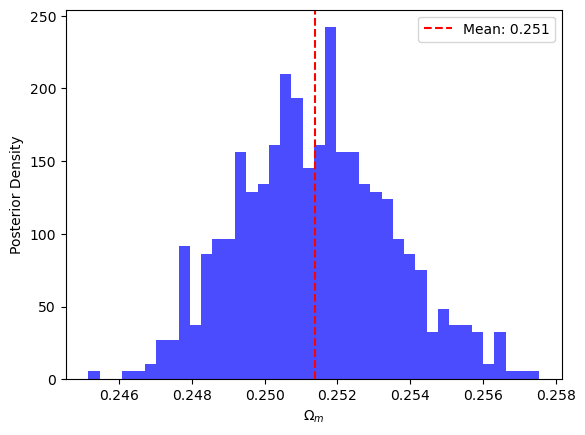

In [273]:
omega_m_samples = samples[:, 0]
mean_omega_m = np.mean(omega_m_samples)
std_omega_m = np.std(omega_m_samples)

plt.hist(omega_m_samples, bins=40, density=True, alpha=0.7, color="blue")
plt.axvline(mean_omega_m, color="red", linestyle="--", label=f"Mean: {mean_omega_m:.3f}")
plt.xlabel(r"$\Omega_m$")
plt.ylabel("Posterior Density")
plt.legend()
plt.savefig("posterior_omega_m.pdf")
plt.show()